In [16]:
!pip install torch torchvision tqdm matplotlib numpy

# **Import Libraries and Setup**

In [17]:
# Import Libraries and Setup
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# **Data Preprocessing and Augmentation**

In [18]:
# Data Preprocessing and Augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# **Data Loading**

In [19]:
# Data Loading
# Set the correct path for Kaggle
data_dir = '/kaggle/input/fruits-classification/Fruits Classification'

# Load datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                 for x in ['train', 'valid', 'test']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
               for x in ['train', 'valid', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes

print("\nDataset Information:")
print(f"Classes: {class_names}")
print("\nDataset sizes:")
for phase in dataset_sizes:
    print(f"{phase}: {dataset_sizes[phase]} images")


Dataset Information:
Classes: ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']

Dataset sizes:
train: 9700 images
valid: 200 images
test: 100 images


# **Data Visualization**


Displaying sample images from training set:


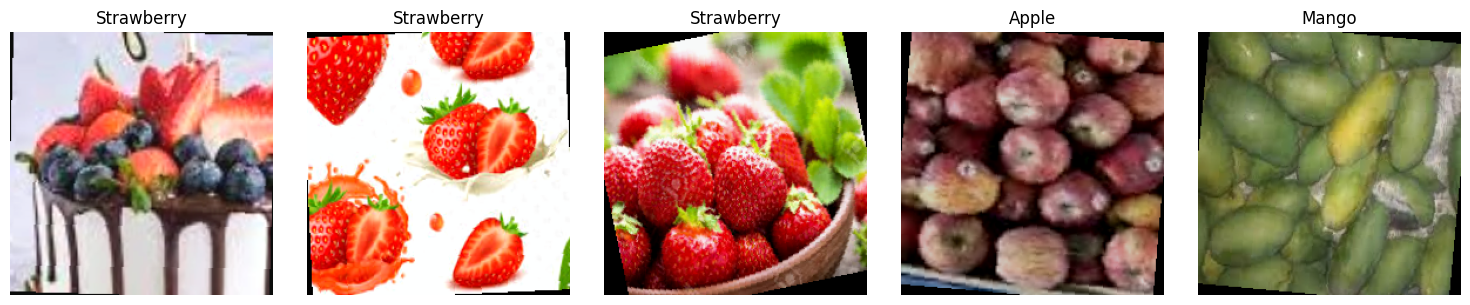

In [20]:
# Data Visualization
def show_samples(dataloader, num_images=5):
    images, labels = next(iter(dataloader))
    images = images[:num_images]
    labels = labels[:num_images]
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    for i, (ax, image, label) in enumerate(zip(axes, images, labels)):
        image = image.numpy().transpose((1, 2, 0))
        image = std * image + mean
        image = np.clip(image, 0, 1)
        
        ax.imshow(image)
        ax.set_title(f'{class_names[label]}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

print("\nDisplaying sample images from training set:")
show_samples(dataloaders['train'])

# **Model Architecture**

In [21]:
# Model Architecture
def initialize_model():
    model = models.resnet50(pretrained=True)
    
    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False
        
    # Replace the final fully connected layer
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, len(class_names))
    )
    
    return model

# **Training Function**

In [22]:
# Training Function
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    best_model_wts = None
    best_acc = 0.0
    
    train_losses, valid_losses = [], []
    train_accs, valid_accs = [], []
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.cpu())
            else:
                valid_losses.append(epoch_loss)
                valid_accs.append(epoch_acc.cpu())
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict().copy()
    
    print(f'\nBest val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    
    # Plot training curves
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(valid_losses, label='Validation')
    plt.title('Loss vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train')
    plt.plot(valid_accs, label='Validation')
    plt.title('Accuracy vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model

# **Model Training Setup and Execution**


Initializing model...


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Starting training...

Epoch 1/15
----------


train: 100%|██████████| 304/304 [00:40<00:00,  7.56it/s]


train Loss: 0.8589 Acc: 0.6755


valid: 100%|██████████| 7/7 [00:00<00:00,  7.16it/s]


valid Loss: 0.5384 Acc: 0.8000

Epoch 2/15
----------


train: 100%|██████████| 304/304 [00:37<00:00,  8.09it/s]


train Loss: 0.7180 Acc: 0.7298


valid: 100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


valid Loss: 0.4547 Acc: 0.8450

Epoch 3/15
----------


train: 100%|██████████| 304/304 [00:38<00:00,  7.81it/s]


train Loss: 0.6736 Acc: 0.7471


valid: 100%|██████████| 7/7 [00:00<00:00,  7.18it/s]


valid Loss: 0.4250 Acc: 0.8400

Epoch 4/15
----------


train: 100%|██████████| 304/304 [00:38<00:00,  7.91it/s]


train Loss: 0.6725 Acc: 0.7492


valid: 100%|██████████| 7/7 [00:00<00:00,  7.26it/s]


valid Loss: 0.4175 Acc: 0.8550

Epoch 5/15
----------


train: 100%|██████████| 304/304 [00:38<00:00,  7.84it/s]


train Loss: 0.6615 Acc: 0.7539


valid: 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]


valid Loss: 0.3679 Acc: 0.8700

Epoch 6/15
----------


train: 100%|██████████| 304/304 [00:38<00:00,  7.87it/s]


train Loss: 0.6513 Acc: 0.7599


valid: 100%|██████████| 7/7 [00:00<00:00,  7.35it/s]


valid Loss: 0.3777 Acc: 0.8800

Epoch 7/15
----------


train: 100%|██████████| 304/304 [00:38<00:00,  7.93it/s]


train Loss: 0.6536 Acc: 0.7654


valid: 100%|██████████| 7/7 [00:00<00:00,  7.19it/s]


valid Loss: 0.4241 Acc: 0.8600

Epoch 8/15
----------


train: 100%|██████████| 304/304 [00:38<00:00,  7.87it/s]


train Loss: 0.5753 Acc: 0.7926


valid: 100%|██████████| 7/7 [00:00<00:00,  7.35it/s]


valid Loss: 0.3498 Acc: 0.8800

Epoch 9/15
----------


train: 100%|██████████| 304/304 [00:38<00:00,  7.86it/s]


train Loss: 0.5737 Acc: 0.7944


valid: 100%|██████████| 7/7 [00:00<00:00,  7.23it/s]


valid Loss: 0.3611 Acc: 0.8800

Epoch 10/15
----------


train: 100%|██████████| 304/304 [00:38<00:00,  7.88it/s]


train Loss: 0.5729 Acc: 0.7919


valid: 100%|██████████| 7/7 [00:00<00:00,  7.22it/s]


valid Loss: 0.3573 Acc: 0.8700

Epoch 11/15
----------


train: 100%|██████████| 304/304 [00:38<00:00,  7.87it/s]


train Loss: 0.5597 Acc: 0.7993


valid: 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


valid Loss: 0.3739 Acc: 0.8750

Epoch 12/15
----------


train: 100%|██████████| 304/304 [00:38<00:00,  7.90it/s]


train Loss: 0.5598 Acc: 0.8025


valid: 100%|██████████| 7/7 [00:00<00:00,  7.21it/s]


valid Loss: 0.3515 Acc: 0.8750

Epoch 13/15
----------


train: 100%|██████████| 304/304 [00:38<00:00,  7.89it/s]


train Loss: 0.5643 Acc: 0.7975


valid: 100%|██████████| 7/7 [00:00<00:00,  7.16it/s]


valid Loss: 0.3557 Acc: 0.8750

Epoch 14/15
----------


train: 100%|██████████| 304/304 [00:38<00:00,  7.86it/s]


train Loss: 0.5471 Acc: 0.8022


valid: 100%|██████████| 7/7 [00:00<00:00,  7.26it/s]


valid Loss: 0.3582 Acc: 0.8750

Epoch 15/15
----------


train: 100%|██████████| 304/304 [00:38<00:00,  7.87it/s]


train Loss: 0.5423 Acc: 0.8042


valid: 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]


valid Loss: 0.3491 Acc: 0.8750

Best val Acc: 0.880000


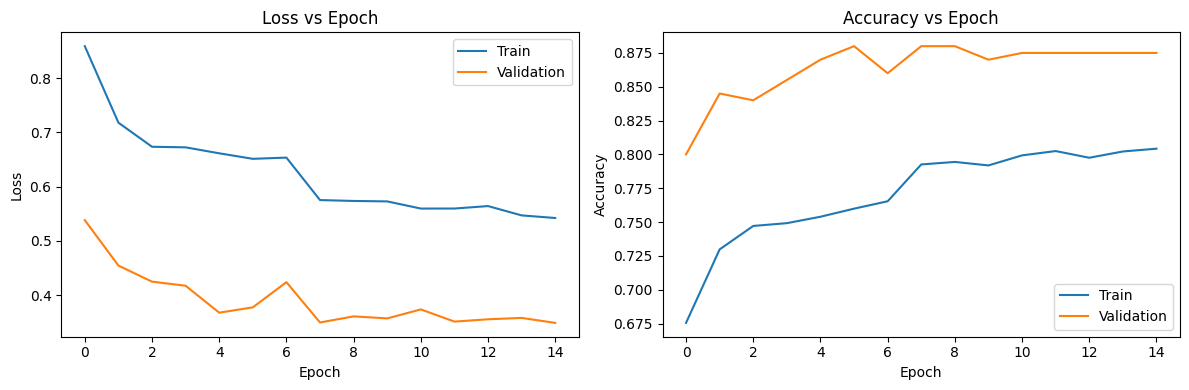

In [23]:
# Model Training Setup and Execution
print("\nInitializing model...")
model = initialize_model()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print("\nStarting training...")
model = train_model(model, criterion, optimizer, scheduler, num_epochs=15)

# **Model Evaluation**

In [24]:
# Model Evaluation
def evaluate_model(model, dataloader):
    model.eval()
    running_corrects = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = running_corrects.double() / len(dataloader.dataset)
    print(f'Test Accuracy: {acc:.4f}')
    
    return all_preds, all_labels

print("\nEvaluating on test set...")
test_preds, test_labels = evaluate_model(model, dataloaders['test'])


Evaluating on test set...


Testing: 100%|██████████| 4/4 [00:00<00:00,  6.28it/s]

Test Accuracy: 0.8800



Testing image from URL: https://www.heddensofwoodtown.co.uk/wp-content/uploads/2020/05/grapes_green_opt.jpg


/tmp/ipykernel_30/3580748727.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(class_names, rotation=45)


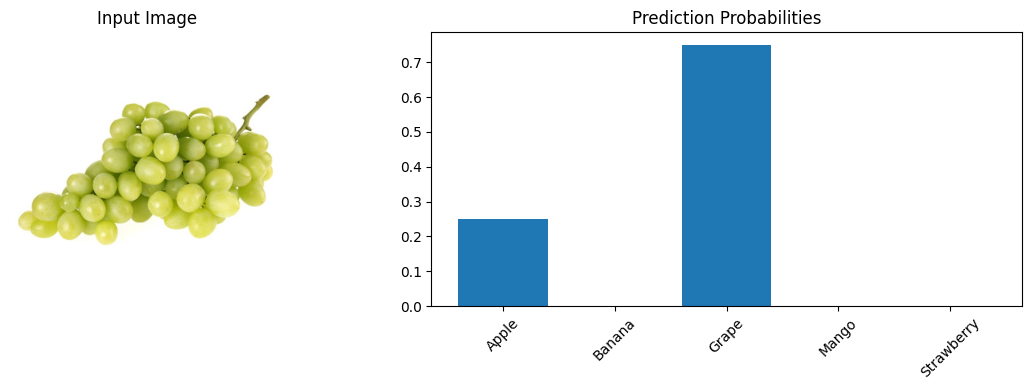


Predicted class: Grape

Class probabilities:
Apple: 0.2500
Banana: 0.0000
Grape: 0.7488
Mango: 0.0012
Strawberry: 0.0000

Testing image from URL: https://static.libertyprim.com/files/familles/pomme-large.jpg


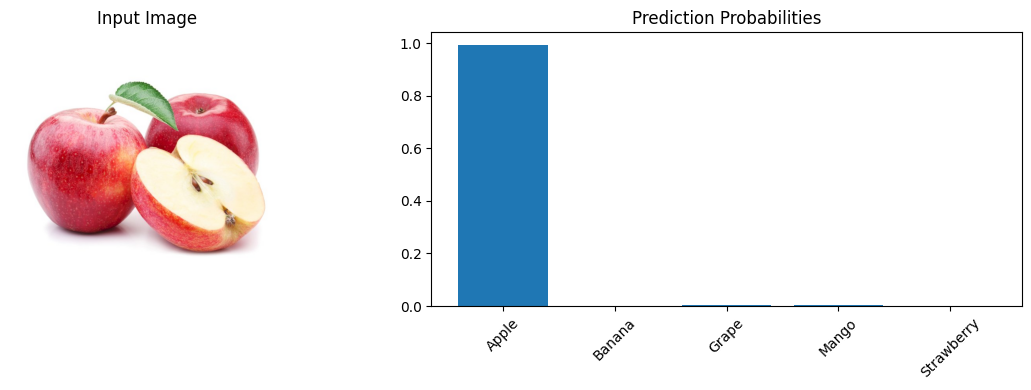


Predicted class: Apple

Class probabilities:
Apple: 0.9918
Banana: 0.0009
Grape: 0.0040
Mango: 0.0023
Strawberry: 0.0011

Testing image from URL: https://www.shutterstock.com/image-photo/banana-cluster-isolated-on-white-260nw-1722111529.jpg


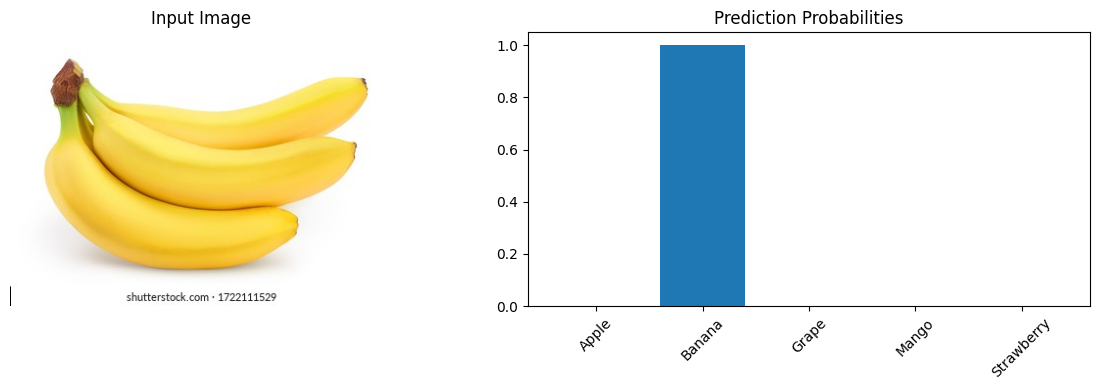


Predicted class: Banana

Class probabilities:
Apple: 0.0000
Banana: 1.0000
Grape: 0.0000
Mango: 0.0000
Strawberry: 0.0000


In [25]:
import requests
from PIL import Image
from io import BytesIO
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

def test_image_from_url(url):
    try:
        # Download and open the image
        response = requests.get(url)
        image = Image.open(BytesIO(response.content))
        
        # Preprocess the image
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        # Transform image
        input_tensor = transform(image)
        input_batch = input_tensor.unsqueeze(0)
        
        # Move to device (CPU/GPU)
        input_batch = input_batch.to(device)
        model.to(device)
        
        # Set model to evaluation mode and get prediction
        model.eval()
        with torch.no_grad():
            output = model(input_batch)
            probabilities = torch.nn.functional.softmax(output[0], dim=0)
            predicted_class = class_names[output.argmax().item()]
        
        # Display results
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Display image
        ax1.imshow(image)
        ax1.axis('off')
        ax1.set_title('Input Image')
        
        # Display probabilities
        probs = probabilities.cpu().numpy()
        ax2.bar(class_names, probs)
        ax2.set_xticklabels(class_names, rotation=45)
        ax2.set_title('Prediction Probabilities')
        
        plt.tight_layout()
        plt.show()
        
        # Print results
        print(f"\nPredicted class: {predicted_class}")
        print("\nClass probabilities:")
        for class_name, prob in zip(class_names, probs):
            print(f"{class_name}: {prob:.4f}")
            
    except Exception as e:
        print(f"Error: {str(e)}")

# Test URLs
urls = [
    "https://www.heddensofwoodtown.co.uk/wp-content/uploads/2020/05/grapes_green_opt.jpg",
    "https://static.libertyprim.com/files/familles/pomme-large.jpg",
    "https://www.shutterstock.com/image-photo/banana-cluster-isolated-on-white-260nw-1722111529.jpg"
]

# Test each image
for url in urls:
    print(f"\nTesting image from URL: {url}")
    test_image_from_url(url)

# **Save Model and Final Summary**

In [26]:
# Save Model and Final Summary
save_path = '/kaggle/working/fruit_classifier.pth'
torch.save(model.state_dict(), save_path)

print("\nTraining completed!")
print(f"Model saved at: {save_path}")
print(f"Number of classes: {len(class_names)}")
print(f"Classes: {class_names}")

# Section 10: Prediction Function (Optional)
def predict_image(image_path, model):
    from PIL import Image
    
    # Load and preprocess the image
    image = Image.open(image_path)
    transform = data_transforms['test']
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        
    return class_names[predicted.item()]


Training completed!
Model saved at: /kaggle/working/fruit_classifier.pth
Number of classes: 5
Classes: ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']
